## Decision Trees Record Data - Python

## Methods
I used a decision tree algorithm to predict what company a given person is from based on record employment data from Revelio Labs. In general, a decision tree is a type of supervised machine learning that categorizes and makes predictions based on how a previous set of questions were answered, where each new answer directs you to a new "node" until a final decision is made by the algorithm. In the context of this data, it means that the algorithm will predict which company (the y variable) a person belongs to based on their answers to various employment demographic questions (the X variable, which contains many categories). 

To feed data into a decision tree model, I have to first ensure that my data is clean. Previously, I already cleaned my record dataset and imputed all NAs, which only existed in the salary column, with medians of each NA's respective "gender" category. Since the record data still contained some categorical variables which cannot be read by the decision tree model, I converted the categories "gender", "ethnicity", "job_category", and "company" to dummy variables in this section. When the data was clean enough to run a decision tree model, I divided the data into variables X and y: X consists of most feature variables, while y is the list of companies. I split a portion (80%) of the X and y into the "training" category and a smaller portion (20%) into the "test" category. 

Then, I fed the training data into the model; in other words, we used the training data, which is the majority of the dataset, to train the decision tree model. The algorithm uses a metric called the Gini index to evaluate each variable. Specifically, the Gini index calculates the probability of guessing the right category or company using only the variable we have right now. Once it comes up with a category, the algorithm then moves on to the next node in the tree. Eventually we will reach the final set of nodes, which is is what leads to a final classification, or "decision", of the tree.  

How will we utilize the remaining 20% of the dataset? I'm glad you asked! Since we used the training data to train the model, it would almost be redundant to use the training data to test how accurate the model is. Hence, we will apply the model to the test data to see how accurate the model is with the unfamiliar data and validate the accuracy of the decision tree model. 

## Set up data

In [1]:
# Load essential libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

# Read csv file
df = pd.read_csv('../data/cleaned_wf_demo.csv', index_col=0)
print(df.head())

      company  seniority job_category  gender ethnicity       count  \
1  Home Depot          4        Admin  female       api    6.649361   
2  Home Depot          3        empty    male       api    0.114460   
3  Home Depot          5    Scientist    male       api    0.005991   
4  Home Depot          1     Engineer    male       api  192.650237   
5  Home Depot          3     Engineer  female       api   84.062919   

      inflow   outflow        salary  
1   0.027259  0.020727  6.296236e+05  
2   0.000265  0.000297  8.108699e+03  
3   0.001000  0.000000  5.206698e+02  
4  10.110865  6.249455  1.124800e+07  
5   1.707721  1.253758  8.842880e+06  


## Clean data for Decision Trees

In [2]:
# Convert categorical variables to dummy variables using pd.get_dummies

# Dummies for job_category
dummies = pd.get_dummies(df['job_category']).rename(columns=lambda x: 'job_category_' + str(x))
df = pd.concat([df, dummies], axis=1) #add back into the dataframe
df.drop(['job_category'], inplace=True, axis = 1) #remove job_category column

# Repeat for gender
dummies = pd.get_dummies(df['gender']).rename(columns=lambda x: 'gender_' + str(x))
df = pd.concat([df, dummies], axis=1) #add back into the dataframe
df.drop(['gender'], inplace=True, axis = 1) #remove gender column

# Repeat for ethnicity
dummies = pd.get_dummies(df['ethnicity']).rename(columns=lambda x: 'ethnicity_' + str(x))
df = pd.concat([df, dummies], axis=1) #add back into the dataframe
df.drop(['ethnicity'], inplace=True, axis = 1) #remove ethnicity column

# Repeat for company
dummies = pd.get_dummies(df['company']).rename(columns=lambda x: 'company_' + str(x))
df = pd.concat([df, dummies], axis=1) #add back into the dataframe

# Confirm new column names and that there are no NAs
print(df.columns)
print(df.isnull().sum())

Index(['company', 'seniority', 'count', 'inflow', 'outflow', 'salary',
       'job_category_Admin', 'job_category_Engineer', 'job_category_Finance',
       'job_category_Marketing', 'job_category_Operations',
       'job_category_Sales', 'job_category_Scientist', 'job_category_empty',
       'gender_female', 'gender_male', 'ethnicity_api', 'ethnicity_black',
       'ethnicity_hispanic', 'ethnicity_multiple', 'ethnicity_native',
       'ethnicity_white', 'company_Accenture', 'company_Apple',
       'company_Bristol Myers Squibb', 'company_Databricks',
       'company_Goldman Sachs', 'company_Home Depot'],
      dtype='object')
company                         0
seniority                       0
count                           0
inflow                          0
outflow                         0
salary                          0
job_category_Admin              0
job_category_Engineer           0
job_category_Finance            0
job_category_Marketing          0
job_category_Operations   

## Class distribution

The classes that we are trying to predict are commpany labels "Home Depot", "Databricks", "Bristol Myers Squibb", "Accenture", "Apple", and "Goldman Sachs". Since these are categorical, we only need to count the frequency of these labels in the "comapany" column of the dataset. Based on the graph below, the labels are pretty evenly distributed, with Accenture having the highest number of labels. We have a majority class of Accenture, but even then the labels are pretty balanced, which means the accuracy score might be pretty high for all classes since we have a large number and similar amounts of data for each class. 

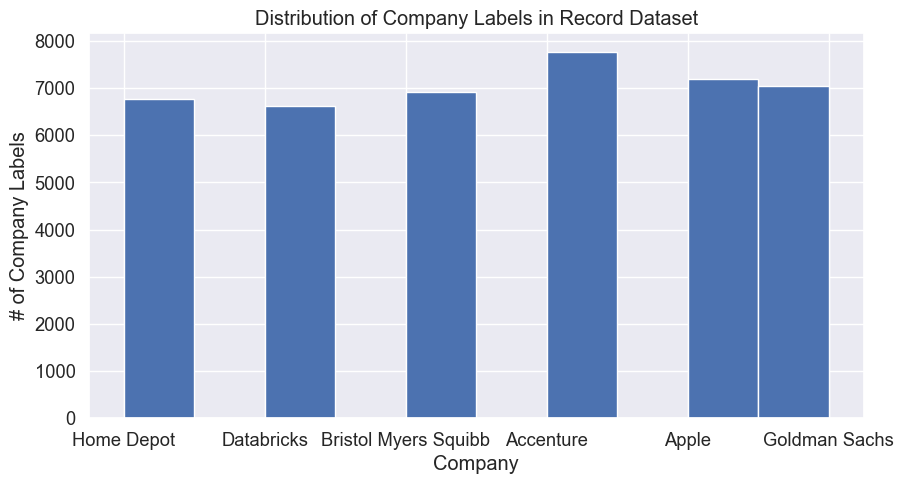

In [3]:
## Examine class distribution
sns.set(font_scale=1.2)

# Visualize class distribution
fig, ax = plt.subplots(figsize=(10,5))
df['company'].hist()
ax.set_title("Distribution of Company Labels in Record Dataset")
ax.set_xlabel("Company")
ax.set_ylabel("# of Company Labels")

# save picture
fig1 = ax.get_figure()
fig1.savefig("../501-project-website/images/DT_record_labels_distribution.png")

## Baseline model

To understand how accurate my upcoming model is, I created a baseline model using a uniform random number generation process. Since in the actual decision tree model the result has 6 categories, we input 6 different labels for this baseline model. The classifier's accuracy, precision, recall, and fscores are below.  

In [4]:
## Baseline model
import random
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def generate_label_data(class_labels, weights,N=10000):
    y=random.choices(class_labels, weights = weights, k = N)
    print("-----GENERATING DATA-----")
    print("unique entries:",Counter(y).keys())  
    print("count of labels:",Counter(y).values()) # counts the elements' frequency
    print("probability of labels:",np.fromiter(Counter(y).values(), dtype=float)/len(y)) # counts the elements' frequency
    return y

## Generate random classifier
def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data); #print(max_label)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("precision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))

# Random classifier
print("\MULTI-CLASS: UNIFORM LOAD")
y=generate_label_data([0,1,2,3,4,5],[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],10000)
random_classifier(y)

\MULTI-CLASS: UNIFORM LOAD
-----GENERATING DATA-----
unique entries: dict_keys([4, 1, 2, 5, 0, 3])
count of labels: dict_values([1718, 1666, 1724, 1641, 1644, 1607])
probability of labels: [0.1718 0.1666 0.1724 0.1641 0.1644 0.1607]
-----RANDOM CLASSIFIER-----
count of prediction: dict_values([1570, 1667, 1706, 1649, 1712, 1696])
probability of prediction: [0.157  0.1667 0.1706 0.1649 0.1712 0.1696]
accuracy 0.1687
precision, recall, fscore, (array([0.16242038, 0.1746513 , 0.17057444, 0.16916617, 0.16391509,
       0.17114486]), array([0.15510949, 0.17286915, 0.1687935 , 0.17548227, 0.16181607,
       0.17854966]), array([0.15868077, 0.17375566, 0.1696793 , 0.17226634, 0.16285882,
       0.17476886]), array([1644, 1666, 1724, 1607, 1718, 1641]))


## Feature selection

To decide on which feature to use, I calculated and ploted a correlation matrix of all the possible feature variables, which is basically every column except for our target "company" column. The correlation of the features are strong along the diagonal, which makes sense because each feature is itself which means each feature has a very strong correlation to itself. Since the job category, gender, and ethnicity groups of features consist of dummy variables, that means male and female, in the context of this dataset, have a -1 correlation with each other. After running this matrix, I decided to leave the count, inflow, and outflow variables out because they are too closely correlated to each other and may not yield distinct and meaningful predictions.

(21, 21)


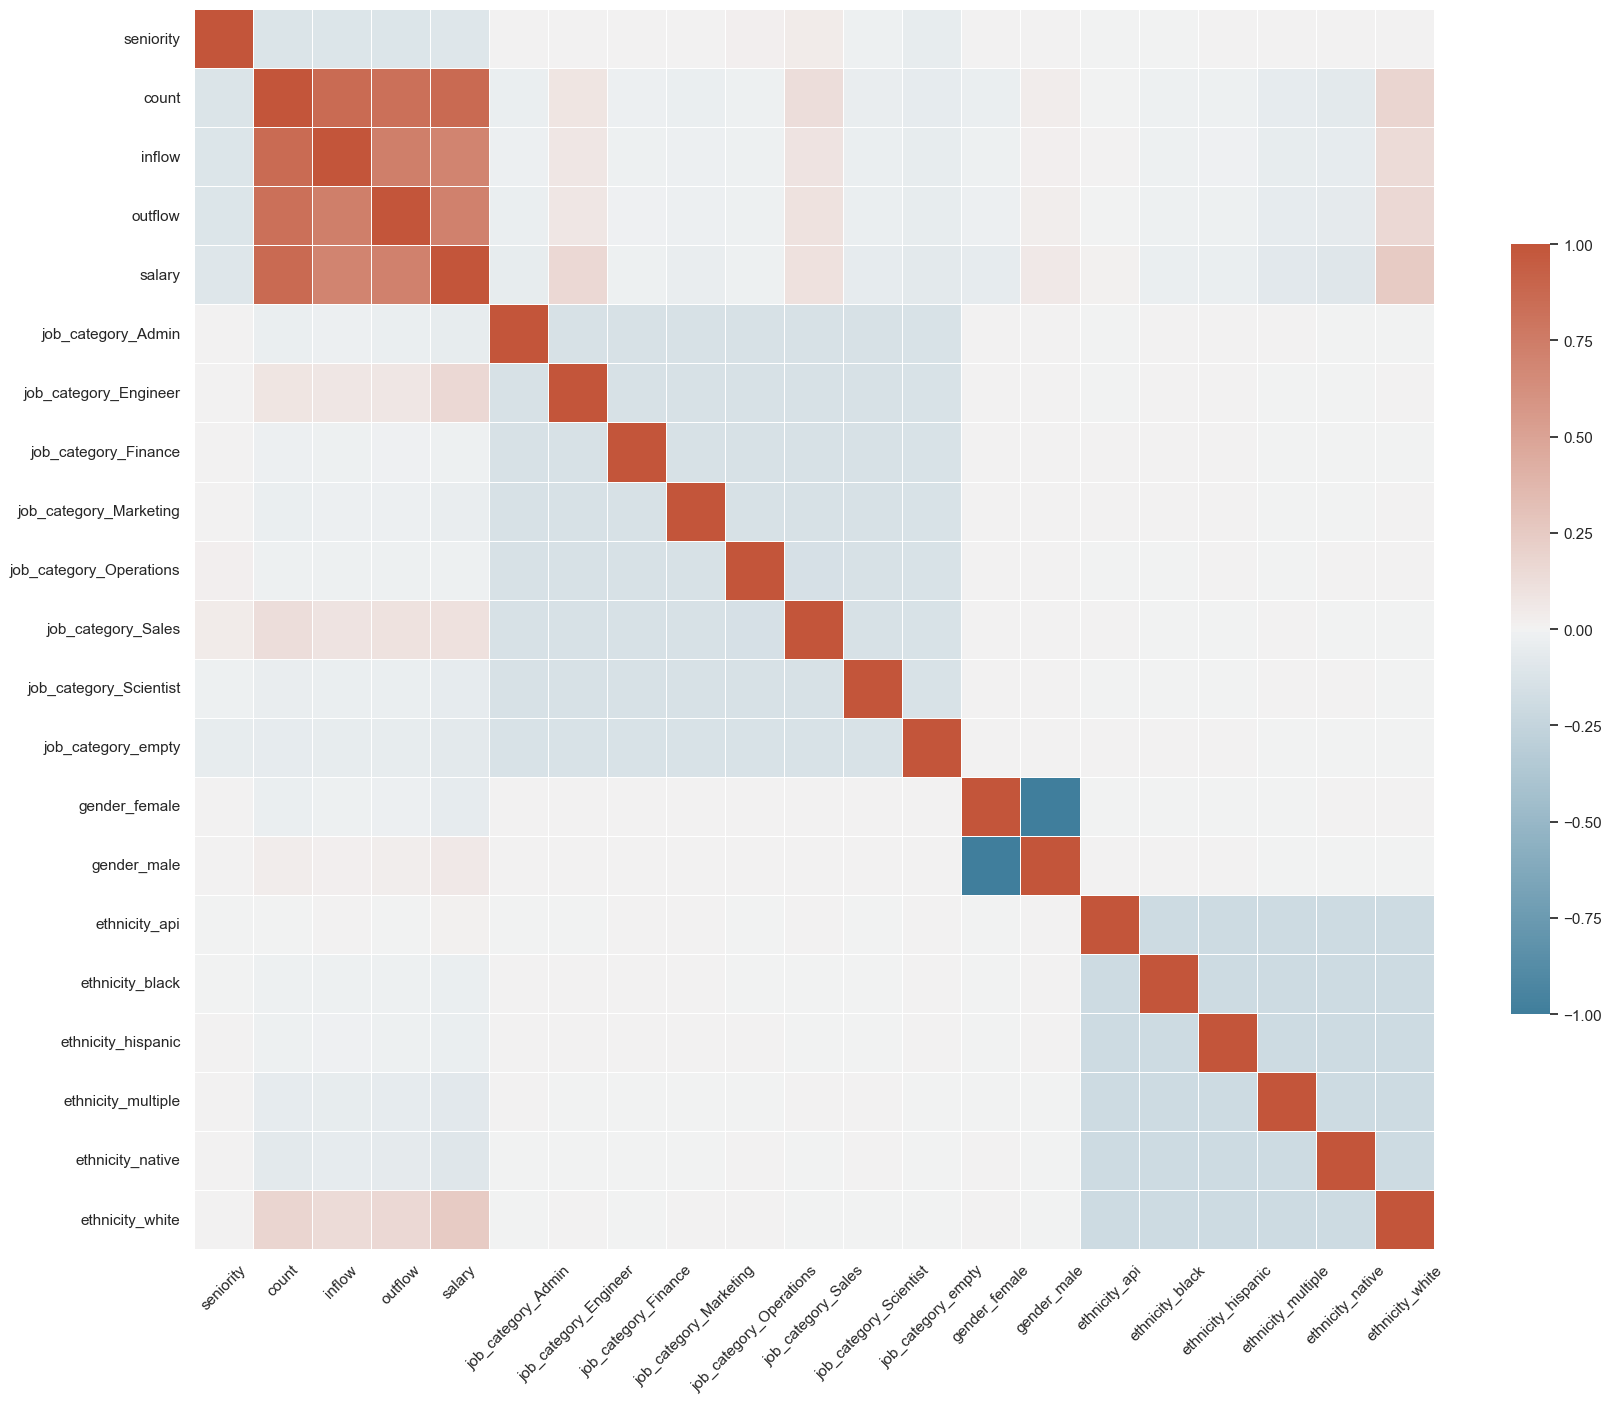

In [5]:
# Identify feature and target columns 
target_cols = [i for i in df.columns if 'company' in i]
feature_cols = df.columns[1:22]

# Display heat-map for the correlation matrix
corr = df[feature_cols].corr(); 
print(corr.shape)
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(20, 20))  # Set up the matplotlib figure
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, vmin=-1, vmax=1, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
# cbar_kws --> removing the shrink will space them out better

plt.xticks(rotation=45)

plt.show()

## Prepare data for Decision Tree model

In [6]:
## SET X AND Y

# y: convert df['company'] string labels to dummy integers
labels=[]; 
y=[]

for label in df["company"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y.append(i)
y = np.array(y)

# X
X = df.drop(['company', 'company_Accenture', 'company_Apple', 'company_Bristol Myers Squibb', 'company_Goldman Sachs', 'company_Home Depot', 'inflow', 'outflow', 'count'], axis = 1)


# Double check
print(X.shape,y.shape)

index = 0 : label = Home Depot
index = 1 : label = Databricks
index = 2 : label = Bristol Myers Squibb
index = 3 : label = Accenture
index = 4 : label = Apple
index = 5 : label = Goldman Sachs
(42336, 19) (42336,)


In [7]:
# Load sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Partion data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)

# Check 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(33868, 19)
(33868,)
(8468, 19)
(8468,)


## Support Vector Classifier

In [8]:
# Initialize model

# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Fit model
model = DecisionTreeClassifier(random_state=0)

model

DecisionTreeClassifier(random_state=0)

In [9]:
# Import sklearn
from sklearn.utils.fixes import sklearn

# Fit model to training data
model.fit(X_train, y_train) 

# Predict on X_train
y_train_pred = model.predict(X_train)

# Predict on X_test
y_test_pred = model.predict(X_test)

## Model Tuning
To find the most accurate model, I itereated the model through tree depths 1 through 30. We want to find the optimal depth so that we don't overfit (model is fit to the training set very well but does not fit the test set well) or underfit (model is not fit to the training set very well but fits the test set well). As seen in the table below, it looks like the higher the number of tree depths, the higher the accuracy scores in general. As a result, I am specifying a high tree depth for the model. 

In [10]:
# Model tuning
from sklearn import tree
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

test_results=[]
train_results=[]

for num_layer in range(1,30):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(X_train, y_train)

    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)

    # print(y_pred.shape)
    test_results.append([
        num_layer,
        accuracy_score(y_test, y_test_pred)])
    train_results.append([
        num_layer,
        accuracy_score(y_train, y_train_pred)])

tuning_train_df = pd.DataFrame(train_results)
tuning_train_df.columns = ["Tree_depth", "train_accuracy_score"]
tuning_test_df = pd.DataFrame(test_results)
tuning_test_df.columns = ["Tree_depth", "test_accuracy_score"]

tuning_df = pd.concat([tuning_train_df, tuning_test_df], axis = 1)
print(tuning_df)

    Tree_depth  train_accuracy_score  Tree_depth  test_accuracy_score
0            1              0.340262           1             0.339632
1            2              0.341768           2             0.333609
2            3              0.376550           3             0.381200
3            4              0.392170           4             0.396434
4            5              0.407760           5             0.406471
5            6              0.414610           6             0.412730
6            7              0.443191           7             0.444143
7            8              0.472747           8             0.468942
8            9              0.499646           9             0.495631
9           10              0.530471          10             0.533420
10          11              0.569121          11             0.566840
11          12              0.618017          12             0.608054
12          13              0.654010          13             0.633089
13          14      

## Final Results

The decision tree model produced has an accuracy score of 99.2% on the training set and 92.8% on the test set. Please see a visualization of the accuracy scores below. This accuracy score indicates that the model has a high quality fit - if anything, the model might be slightly overfitted because the accuracy for test data is lower by 7%, but a lower accuracy score for test data is expected and at the end of the day the model's accuracy on the test set still exceeds the 85% threshold for a model to be considered accurate. 

When we plot the decision tree, we can see that the model produced many nodes to generate such accurate predictions. However, one cost of this high level of accuracy is that the run-time is relatively long. Precisely, it took 3.5 minutes to generate this plot. That suggests that to improve the appicability of the model, we might want to tune it less and sacrifice some accuracy for efficiency, especially if we might apply the model on a large dataset.

Please also see a visualization of the confusion score below. The score is highest for label 3, which is "Accenture" - this makes sense because Accenture has the highest number of data points, which would imply a higher accuracy of prediction since there is more data to train the model on predicting the label "Accenture". Generally speaking, the diagonal of the confusion matrix is dark blue whereas the other boxes are faintly colored, indicating that there is a high number of correct predictions. 


Training set
Accuracy:  99.22640840911775
Number of mislabeled points:  262
Test set
Accuracy:  92.77279168634861
Number of mislabeled points:  612


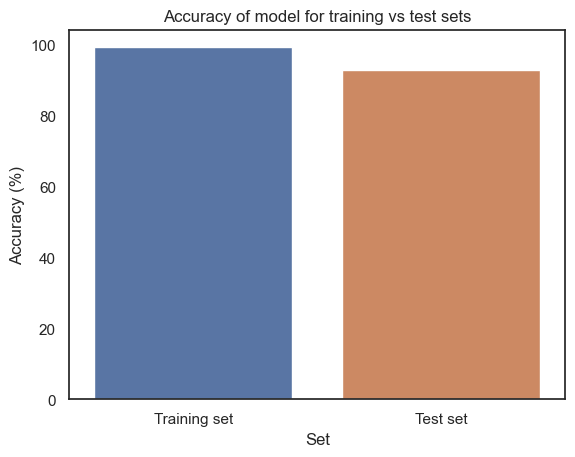

In [11]:
# TEST ACCURACY

# Training set
print("Training set")
print("Accuracy: ", accuracy_score(y_train, y_train_pred) * 100) #accuracy score
print("Number of mislabeled points: ", (y_train != y_train_pred).sum()) #mislabeled points

# Test set
y_test_pred = model.predict(X_test)
print("Test set")
print("Accuracy: ", accuracy_score(y_test, y_test_pred)*100) #accuracy score
print("Number of mislabeled points: ", (y_test != y_test_pred).sum()) #mislabeled points

# Plot
model_accuracies = pd.DataFrame({'Set':['Training set','Test set'], 'Accuracy (%)': [accuracy_score(y_train, y_train_pred) * 100, accuracy_score(y_test, y_test_pred)*100]})
sns.barplot(data=model_accuracies, x="Set", y="Accuracy (%)").set(title = 'Accuracy of model for training vs test sets' )
plt.savefig("../501-project-website/images/DT_record_accuracy.png")

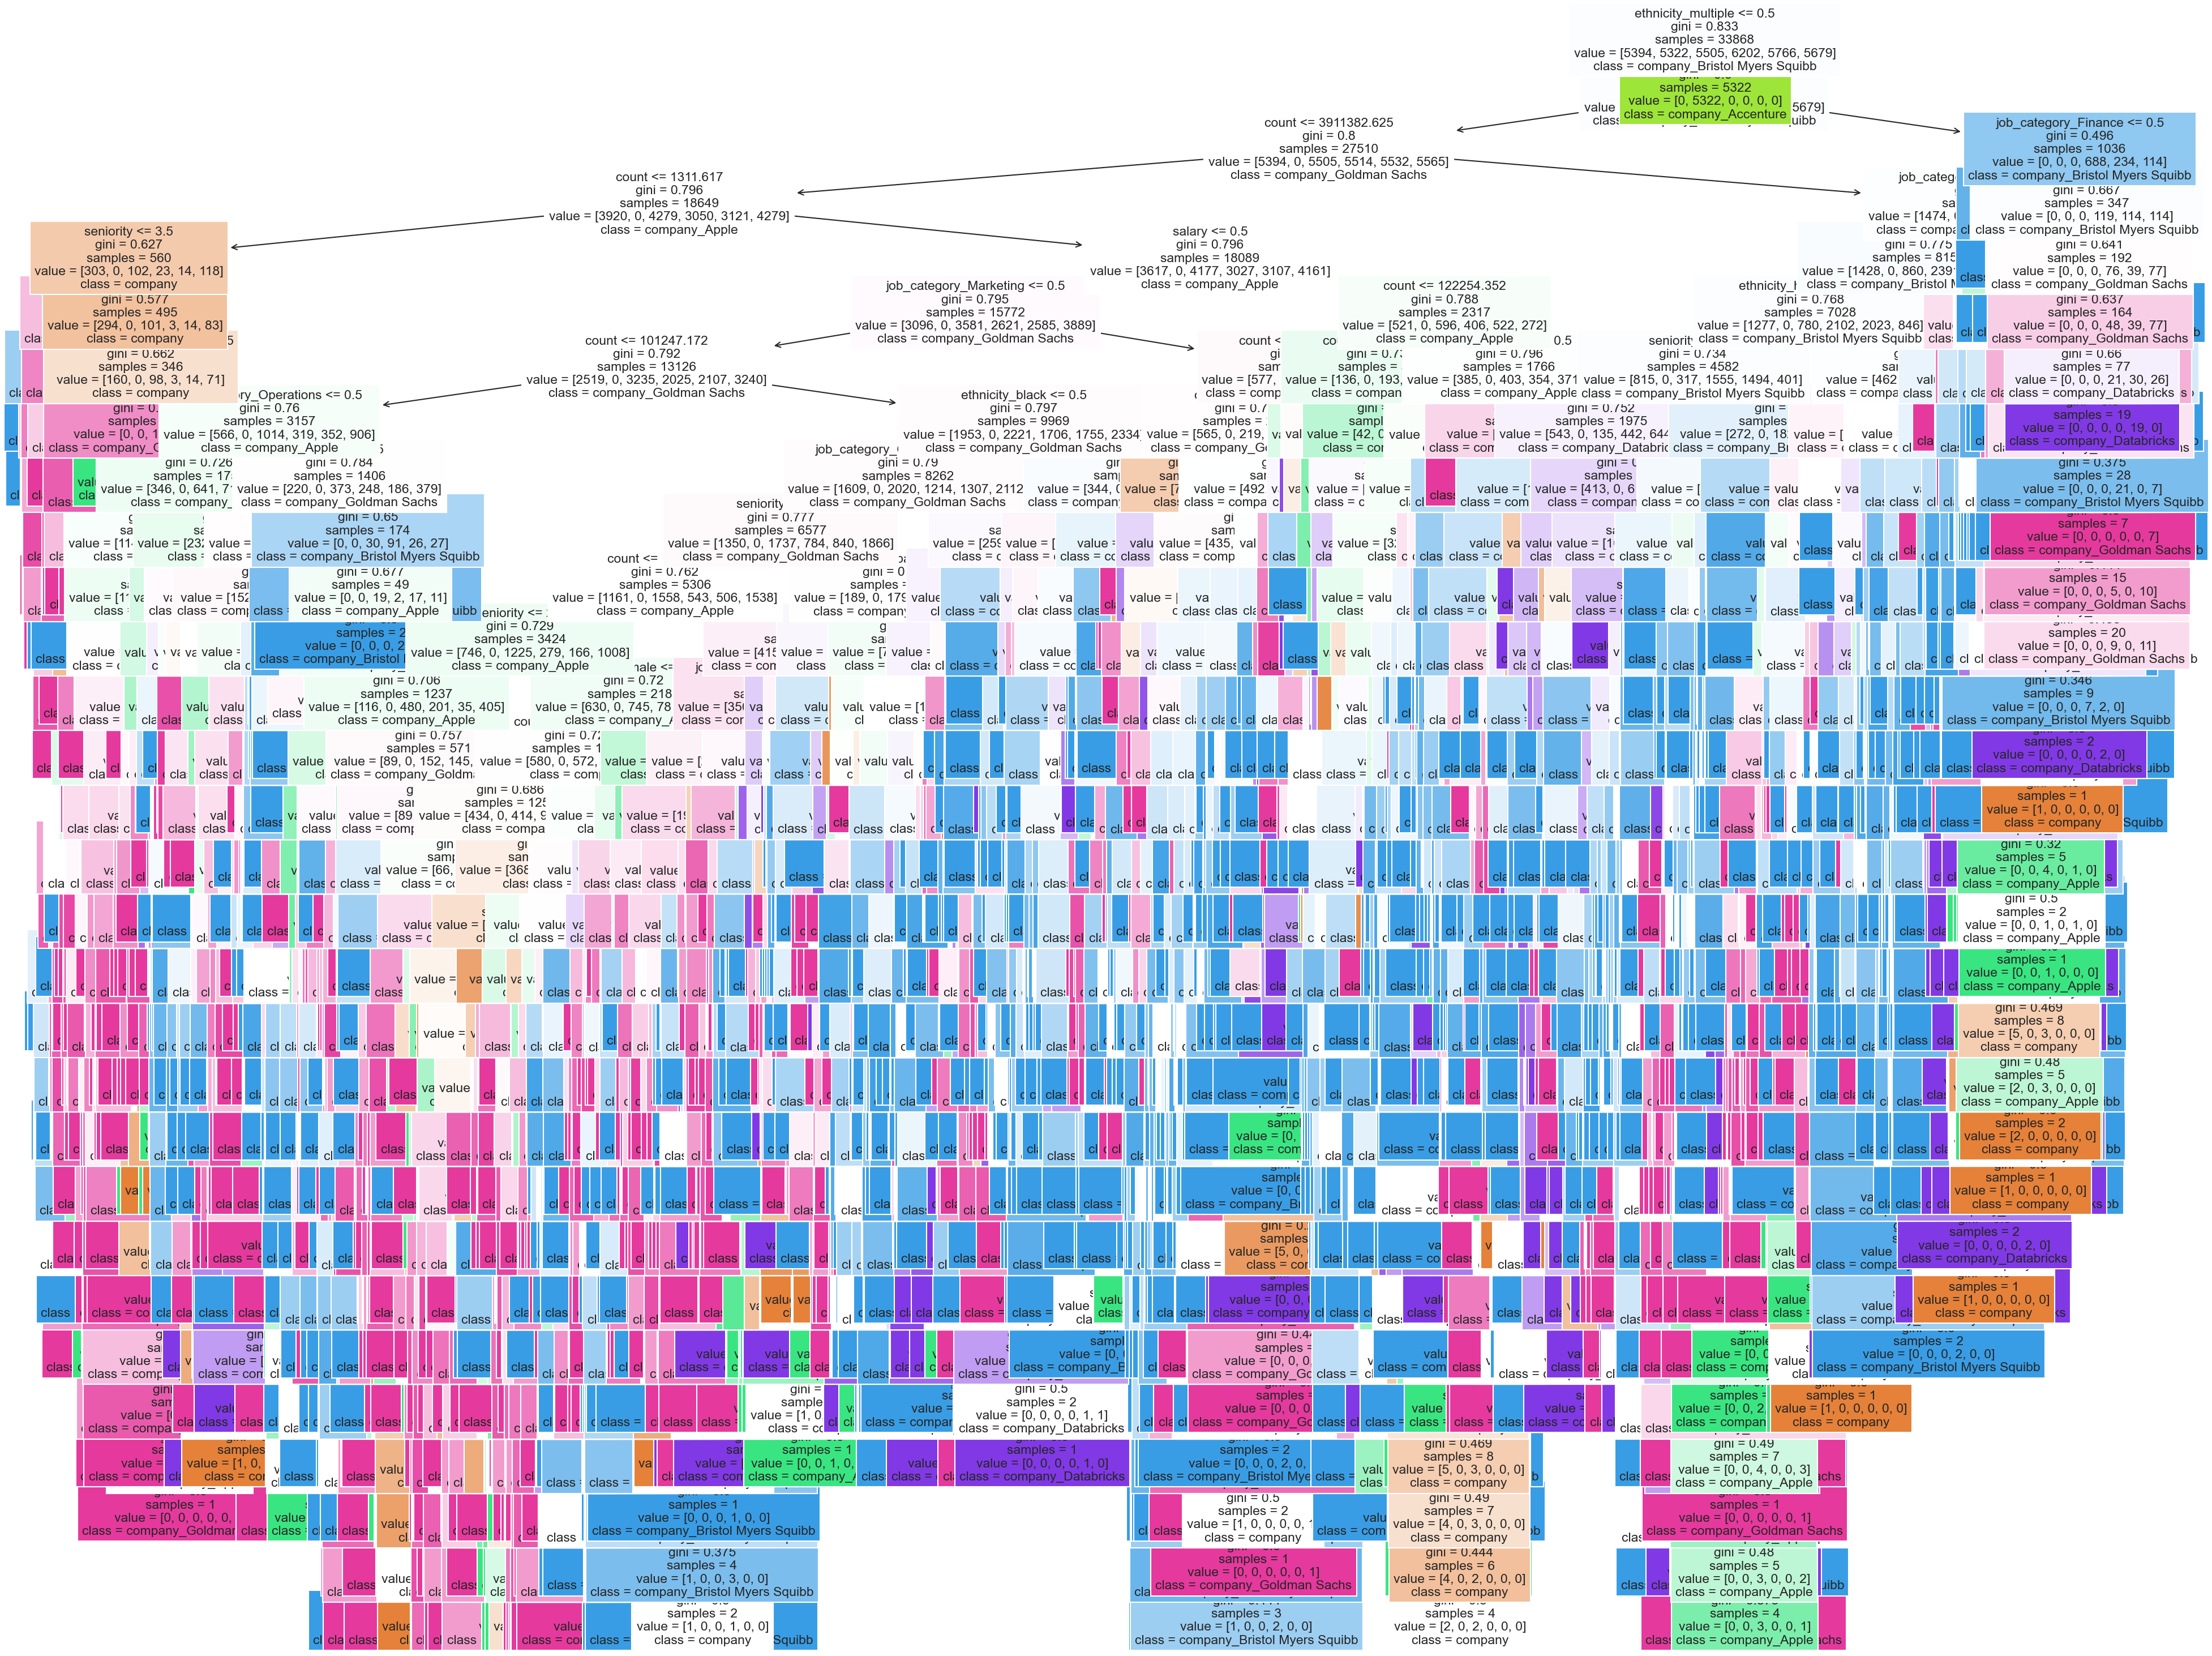

In [12]:
# DECISION TREE

# Import decision tree libraries
from dtreeviz.trees import tree
import graphviz

# Plot decision tree
def plot_tree(model, X, Y):
    fig = plt.figure(figsize=(30, 25), dpi=150)
    _ = tree.plot_tree(model,
                      feature_names = feature_cols,
                       class_names = target_cols,
                       filled = True,
                      fontsize=11)
    fig.savefig('../501-project-website/images/DT_graph.png')
    
plot_tree(model, X, y)

/Users/cynthiang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


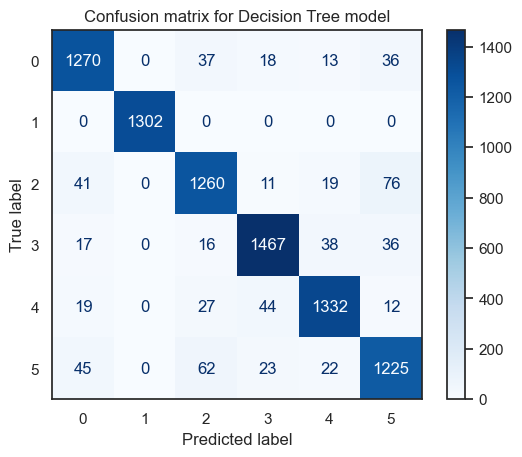

In [13]:
# CONFUSION MATRIX

# Import confusion matrix library
from sklearn.metrics import plot_confusion_matrix

# Create confusion matrix
plot_confusion_matrix(model, X_test , y_test , cmap="Blues")

# Plot confusion matrix
plt.title("Confusion matrix for Decision Tree model")
plt.savefig("../501-project-website/images/DT_record_confusion_matrix.png")

## Conclusions
In conclusion, I think this decision tree model is a high quality model due to the high accuracy scores for both training and test sets. In addition, the accuracy scores exceed the 85% threshold for a model to be considered accurate. 

The fact that there is such a high correlation between the predicted and true labels, given features such as gender, ethnicity, and salary, show that each company has its own distinct workforce demographic––for better or worse. For example, in the feature selection graph, we see that of the six different ethnicity categories, the white category is most postiively correlated with salary and seniority, which reflects the differing race-based outcomes.

To explore further, I hope to see which companies are more correlated with different extents of various features. In addition, I hope that these results generate a clearer picture of how people from different genders and races experience different levels of employment outcomes, and provide a general impetus for companies to more intentionally prioritize diveristy, equity, and inclusion in their workforce.